In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import json
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations

In [2]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol.to_list()
timeframe = '5y'
start_cash = 10_000

In [3]:
df=yf.download(tickers, period=timeframe)['Close']

/var/folders/pc/lwrwx3mn1jq97mrd103w8tm80000gn/T/ipykernel_35546/896026501.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(tickers, period=timeframe)['Close']
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y)')


In [4]:
def adftest(stock1, stock2, df):
    x = df[stock1].values
    x = sm.add_constant(x)
    y = df[stock2].values

    model = sm.OLS(y,x).fit()
    intercept, slope = model.params
    residuals = y - (intercept + slope*x[:,1])
    if np.isnan(residuals).any():
        return np.nan
    result = adfuller(residuals)
    return result[0], result[1], slope, intercept

In [5]:
def test_coint (tickers=tickers, timeframe=timeframe, df = df):

    combination_df = pd.DataFrame(combinations(df.columns,2))
    combination_df.columns = ['Stock1','Stock2']
    combination_df['Correlation'] = combination_df.apply(lambda row: np.corrcoef(df[row['Stock1']],df[row['Stock2']])[0,1],axis=1)
    combination_df = combination_df[combination_df['Correlation'] > 0.95]
    combination_df[['adf_stat','p-value,','Slope','Intercept']] = combination_df.apply(lambda row: pd.Series(adftest(row['Stock1'], row['Stock2'],df)),axis=1)
    return combination_df


In [6]:
print(test_coint())


       Stock1 Stock2  Correlation  adf_stat  p-value,      Slope   Intercept
1048     ABBV    AZO     0.958215 -3.814833  0.002759  20.465938 -409.689256
1076     ABBV     CB     0.960987 -4.370221  0.000335   1.359728   23.011264
2509     ACGL    AFL     0.955330 -2.196097  0.207665   0.887917   13.286827
2708     ACGL    GWW     0.966569 -4.052641  0.001159  10.185383   32.316224
2725     ACGL   HUBB     0.962033 -4.238429  0.000567   3.866228   22.773597
...       ...    ...          ...       ...       ...        ...         ...
125821    VST    WAB     0.952036 -0.729068  0.839076   0.829276   74.088703
125832    VST    WMT     0.971166 -3.240614  0.017751   0.347458   38.740733
125937    WAB    WMB     0.962778 -2.071105  0.256291   0.280722   -0.462065
126084   WELL    WMB     0.956258 -2.576117  0.098035   0.419566   -4.322820
126134    WMB    WRB     0.959565 -2.996796  0.035195   0.959464   12.429129

[844 rows x 7 columns]


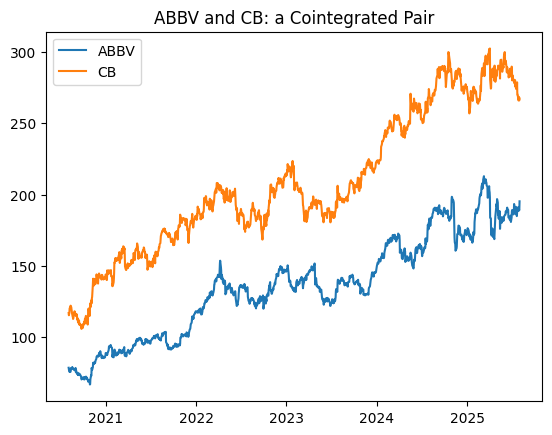

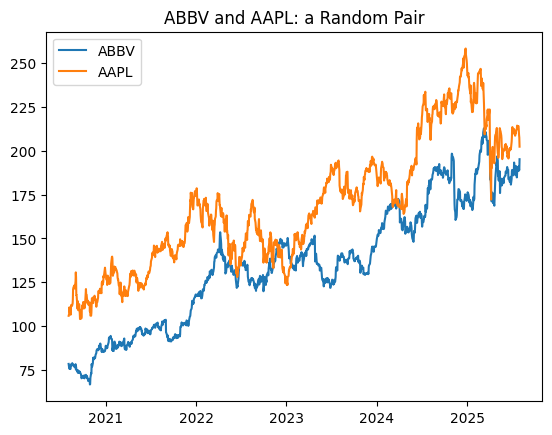

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title('ABBV and CB: a Cointegrated Pair')
ax.plot(df['ABBV'], label = 'ABBV')
ax.plot(df['CB'], label = 'CB')
ax.legend()


fig, ax = plt.subplots()
plt.title('ABBV and AAPL: a Random Pair')
ax.plot(df['ABBV'], label = 'ABBV')
ax.plot(df['AAPL'], label = 'AAPL')
ax.legend()
plt.show()

plt.show()


